In [3]:
import os
os.chdir('..')

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import tqdm
import pickle as pkl

pd.options.display.max_colwidth=500

In [206]:
def find_bboxes(image, boar_points):
    image_gray = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(image_gray, 40,100)
    cont_image, contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = [cv2.convexHull(c) for c in contours]
    
    bboxes = []
    for x, y in boar_points:
        matching_contours = []
        all_contours = []
        for contour in contours:
            dist_from_contour = cv2.pointPolygonTest(contour, (x,y), True)
            if dist_from_contour >= 0:
                matching_contours.append({'contour': contour, 
                                          'area': cv2.contourArea(contour), 
                                          'distance': dist_from_contour})
            elif abs(dist_from_contour) <= 0.03 * min(image.shape[:2]):
                all_contours.append({'contour': contour,
                                     'area': cv2.contourArea(contour), 
                                     'distance': abs(dist_from_contour)})
        if matching_contours:
            contour = min(matching_contours, key=lambda x: x['area'])['contour']
            x, y, w, h = cv2.boundingRect(contour)
            bboxes.append((max(0, x-1), 
                           max(0, y-1),
                           min(image.shape[1], x+w+1),
                           min(image.shape[0], y+h+1)))
        elif all_contours:
            contour = min(all_contours, key=lambda x: x['distance'])['contour']
            x, y, w, h = cv2.boundingRect(contour)
            bboxes.append((max(0, x-1), 
                           max(0, y-1),
                           min(image.shape[1], x+w+1),
                           min(image.shape[0], y+h+1)))
        else:
            bboxes.append(None)
    return bboxes

In [10]:
def load_video_frame(filename, second, interest_frame, offset):
    cap = cv2.VideoCapture(filename)
    frames = []
    for i in range(second * 30 + int(interest_frame/15 * 30) + offset):
        ret, frame = cap.read()
        frames.append(frame)
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    cap.release()
    return frame

# Loading data

In [6]:
!ls data/arma_generated/20fps_sample/

2018-12-10_16-22-04.mp4  20fps_test.zip  7.csv


In [4]:
df = pd.read_csv('./data/arma_generated/20fps_sample/7.csv')
df

,timestamp,frame,objects
0,2018-12-10 16:22:04,1,"[[0, 454.903, -21.7134], [1, 476.824, -9.25929], [2, 498.533, -6.07463], [3, 934.065, -579.122], [4, 995.605, -594.476], [5, 882.837, -1245.65], [6, 812.231, -1279.96], [7, 850.914, -1408.31], [8, 1413.81, -3433.38], [9, 1658.82, -3903.72]]"
1,2018-12-10 16:22:04,2,"[[0, 454.901, -17.7646], [1, 476.782, -5.20606], [2, 498.532, -2.11599], [3, 935.191, -575.456], [4, 985.804, -585.876], [5, 882.842, -1240.39], [6, 812.236, -1274.7], [7, 850.607, -1400.23], [8, 1415.42, -3432.78], [9, 1659.13, -3895.54]]"
2,2018-12-10 16:22:04,3,"[[0, 454.902, -19.3441], [1, 476.782, -6.78994], [2, 498.532, -3.69943], [3, 935.189, -577.402], [4, 990.083, -587.639], [5, 882.84, -1242.49], [6, 812.234, -1276.8], [7, 850.605, -1402.41], [8, 1415.41, -3435.89], [9, 1659.12, -3898.94]]"
3,2018-12-10 16:22:04,12,"[[0, 454.903, -22.5032], [1, 476.828, -10.2306], [2, 498.533, -6.86633], [3, 932.599, -577.793], [4, 995.604, -595.473], [5, 882.836, -1246.7], [6, 812.231, -1281.01], [7, 850.936, -1409.59], [8, 1413.62, -3434.63], [9, 1658.55, -3905.16]]"
4,2018-12-10 16:22:04,14,"[[0, 454.902, -20.9236], [1, 476.824, -8.46759], [2, 498.533, -5.28288], [3, 934.066, -578.149], [4, 990.08, -589.626], [5, 882.838, -1244.6], [6, 812.232, -1278.9], [7, 850.915, -1407.22], [8, 1413.81, -3431.83], [9, 1658.83, -3902.02]]"
5,2018-12-10 16:22:04,16,"[[0, 454.902, -20.1339], [1, 476.824, -7.6758], [2, 498.532, -4.49118], [3, 934.067, -577.176], [4, 990.082, -588.632], [5, 882.839, -1243.55], [6, 812.233, -1277.85], [7, 850.917, -1406.13], [8, 1413.82, -3430.28], [9, 1658.83, -3900.32]]"
6,2018-12-10 16:22:05,4,"[[0, 454.9, -14.6055], [1, 476.766, -1.88322], [2, 498.531, 1.05099], [3, 936.338, -572.831], [4, 980.74, -580.222], [5, 882.847, -1236.19], [6, 812.239, -1270.49], [7, 850.583, -1395.63], [8, 1415.89, -3428.14], [9, 1659.44, -3889.07]]"
7,2018-12-10 16:22:05,5,"[[0, 454.899, -10.6565], [1, 476.755, 2.42971], [2, 498.531, 5.00974], [3, 938.962, -571.535], [4, 976.796, -576.405], [5, 882.852, -1230.93], [6, 812.244, -1265.23], [7, 850.53, -1389.68], [8, 1416.09, -3420.6], [9, 1661.89, -3888.95]]"
8,2018-12-10 16:22:05,7,"[[0, 454.901, -16.9748], [1, 476.767, -4.25922], [2, 498.532, -1.3242], [3, 935.192, -574.484], [4, 985.805, -584.883], [5, 882.843, -1239.34], [6, 812.237, -1273.64], [7, 850.608, -1399.14], [8, 1415.42, -3431.23], [9, 1659.14, -3893.84]]"
9,2018-12-10 16:22:05,8,"[[0, 454.901, -15.3953], [1, 476.766, -2.67518], [2, 498.531, 0.259227], [3, 936.337, -573.804], [4, 985.808, -582.896], [5, 882.845, -1237.24], [6, 812.239, -1271.54], [7, 850.582, -1396.72], [8, 1415.88, -3429.69], [9, 1659.43, -3890.78]]"


In [5]:
df['objects'] = df['objects'].apply(lambda obj: np.asarray([[x,y] for o,x,y in eval(obj)]))
df

,timestamp,frame,objects
0,2018-12-10 16:22:04,1,"[[454.903, -21.7134], [476.824, -9.25929], [498.533, -6.07463], [934.065, -579.122], [995.605, -594.476], [882.837, -1245.65], [812.231, -1279.96], [850.914, -1408.31], [1413.81, -3433.38], [1658.82, -3903.72]]"
1,2018-12-10 16:22:04,2,"[[454.901, -17.7646], [476.782, -5.20606], [498.532, -2.11599], [935.191, -575.456], [985.804, -585.876], [882.842, -1240.39], [812.236, -1274.7], [850.607, -1400.23], [1415.42, -3432.78], [1659.13, -3895.54]]"
2,2018-12-10 16:22:04,3,"[[454.902, -19.3441], [476.782, -6.78994], [498.532, -3.69943], [935.189, -577.402], [990.083, -587.639], [882.84, -1242.49], [812.234, -1276.8], [850.605, -1402.41], [1415.41, -3435.89], [1659.12, -3898.94]]"
3,2018-12-10 16:22:04,12,"[[454.903, -22.5032], [476.828, -10.2306], [498.533, -6.86633], [932.599, -577.793], [995.604, -595.473], [882.836, -1246.7], [812.231, -1281.01], [850.936, -1409.59], [1413.62, -3434.63], [1658.55, -3905.16]]"
4,2018-12-10 16:22:04,14,"[[454.902, -20.9236], [476.824, -8.46759], [498.533, -5.28288], [934.066, -578.149], [990.08, -589.626], [882.838, -1244.6], [812.232, -1278.9], [850.915, -1407.22], [1413.81, -3431.83], [1658.83, -3902.02]]"
5,2018-12-10 16:22:04,16,"[[454.902, -20.1339], [476.824, -7.6758], [498.532, -4.49118], [934.067, -577.176], [990.082, -588.632], [882.839, -1243.55], [812.233, -1277.85], [850.917, -1406.13], [1413.82, -3430.28], [1658.83, -3900.32]]"
6,2018-12-10 16:22:05,4,"[[454.9, -14.6055], [476.766, -1.88322], [498.531, 1.05099], [936.338, -572.831], [980.74, -580.222], [882.847, -1236.19], [812.239, -1270.49], [850.583, -1395.63], [1415.89, -3428.14], [1659.44, -3889.07]]"
7,2018-12-10 16:22:05,5,"[[454.899, -10.6565], [476.755, 2.42971], [498.531, 5.00974], [938.962, -571.535], [976.796, -576.405], [882.852, -1230.93], [812.244, -1265.23], [850.53, -1389.68], [1416.09, -3420.6], [1661.89, -3888.95]]"
8,2018-12-10 16:22:05,7,"[[454.901, -16.9748], [476.767, -4.25922], [498.532, -1.3242], [935.192, -574.484], [985.805, -584.883], [882.843, -1239.34], [812.237, -1273.64], [850.608, -1399.14], [1415.42, -3431.23], [1659.14, -3893.84]]"
9,2018-12-10 16:22:05,8,"[[454.901, -15.3953], [476.766, -2.67518], [498.531, 0.259227], [936.337, -573.804], [985.808, -582.896], [882.845, -1237.24], [812.239, -1271.54], [850.582, -1396.72], [1415.88, -3429.69], [1659.43, -3890.78]]"


In [13]:
df.objects.apply(lambda x : isinstance(x,np.ndarray)).all()

True

In [17]:
df.objects.apply(lambda x: x.shape[1]==2).all()

True

In [9]:
df.describe()

,frame
count,1000.000000
mean,9.251000
std,5.543169
min,0.000000
25%,4.000000
50%,9.000000
75%,14.000000
max,19.000000


In [8]:
df.groupby('timestamp').count().describe()

,frame,objects
count,82.000000,82.000000
mean,12.195122,12.195122
std,1.666215,1.666215
min,5.000000,5.000000
25%,12.000000,12.000000
50%,12.000000,12.000000
75%,13.000000,13.000000
max,16.000000,16.000000


In [19]:
cap = cv2.VideoCapture('data/arma_generated/20fps_sample/2018-12-10_16-22-04.mp4')
frames = []
ret = True
while ret:
    ret, frame = cap.read()
    if ret:
        frames.append(frame)
cap.release()

In [21]:
len(frames), len(df)

(2075, 1000)

# Interpolating annotations

In [23]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.dtypes

timestamp    datetime64[ns]
frame                 int64
objects              object
dtype: object

In [87]:
min_second = datetime.strptime('2018-12-10 16:22:04', '%Y-%m-%d %H:%M:%S')
frame_shift = 20 -df[df['timestamp'] == df['timestamp'].min()]['frame'].max()
max_second = min_second + timedelta(seconds=int(len(frames)/20))
max_second, min_second, frame_shift

(datetime.datetime(2018, 12, 10, 16, 23, 47),
 datetime.datetime(2018, 12, 10, 16, 22, 4),
 4)

In [106]:
duration = df.timestamp.max() - df.timestamp.min()
duration

Timedelta('0 days 00:01:21')

In [112]:
referential_steps = []
for sec in range(duration.seconds + 1):
    dtm = min_second + timedelta(seconds=sec)
    for frame_nb in range(20):
        if (dtm < df['timestamp'].max() 
            or frame_nb <= df[df['timestamp'] == df['timestamp'].max()]['frame'].max()):
            referential_steps.append((dtm, frame_nb))

referential_df = pd.DataFrame(referential_steps, columns=['timestamp', 'frame'])
referential_df

,timestamp,frame
0,2018-12-10 16:22:04,0
1,2018-12-10 16:22:04,1
2,2018-12-10 16:22:04,2
3,2018-12-10 16:22:04,3
4,2018-12-10 16:22:04,4
5,2018-12-10 16:22:04,5
6,2018-12-10 16:22:04,6
7,2018-12-10 16:22:04,7
8,2018-12-10 16:22:04,8
9,2018-12-10 16:22:04,9


In [210]:
annotation = referential_df.merge(df, how='left', on=['timestamp','frame'])
annotation

,timestamp,frame,objects
0,2018-12-10 16:22:04,0,NaN
1,2018-12-10 16:22:04,1,"[[454.903, -21.7134], [476.824, -9.25929], [498.533, -6.07463], [934.065, -579.122], [995.605, -594.476], [882.837, -1245.65], [812.231, -1279.96], [850.914, -1408.31], [1413.81, -3433.38], [1658.82, -3903.72]]"
2,2018-12-10 16:22:04,2,"[[454.901, -17.7646], [476.782, -5.20606], [498.532, -2.11599], [935.191, -575.456], [985.804, -585.876], [882.842, -1240.39], [812.236, -1274.7], [850.607, -1400.23], [1415.42, -3432.78], [1659.13, -3895.54]]"
3,2018-12-10 16:22:04,3,"[[454.902, -19.3441], [476.782, -6.78994], [498.532, -3.69943], [935.189, -577.402], [990.083, -587.639], [882.84, -1242.49], [812.234, -1276.8], [850.605, -1402.41], [1415.41, -3435.89], [1659.12, -3898.94]]"
4,2018-12-10 16:22:04,4,NaN
5,2018-12-10 16:22:04,5,NaN
6,2018-12-10 16:22:04,6,NaN
7,2018-12-10 16:22:04,7,NaN
8,2018-12-10 16:22:04,8,NaN
9,2018-12-10 16:22:04,9,NaN


In [211]:
def interpolate(series):
    temp = series.copy()
    data = temp._data.interpolate()
    temp._data = data
    return temp

In [213]:
annotation['objects'] = interpolate(annotation['objects']).fillna(method='bfill')
annotation

,timestamp,frame,objects
0,2018-12-10 16:22:04,0,"[[454.903, -21.7134], [476.824, -9.25929], [498.533, -6.07463], [934.065, -579.122], [995.605, -594.476], [882.837, -1245.65], [812.231, -1279.96], [850.914, -1408.31], [1413.81, -3433.38], [1658.82, -3903.72]]"
1,2018-12-10 16:22:04,1,"[[454.903, -21.7134], [476.824, -9.25929], [498.533, -6.07463], [934.065, -579.122], [995.605, -594.476], [882.837, -1245.65], [812.231, -1279.96], [850.914, -1408.31], [1413.81, -3433.38], [1658.82, -3903.72]]"
2,2018-12-10 16:22:04,2,"[[454.901, -17.7646], [476.782, -5.20606], [498.532, -2.11599], [935.191, -575.456], [985.804, -585.876], [882.842, -1240.39], [812.236, -1274.7], [850.607, -1400.23], [1415.42, -3432.78], [1659.13, -3895.54]]"
3,2018-12-10 16:22:04,3,"[[454.902, -19.3441], [476.782, -6.78994], [498.532, -3.69943], [935.189, -577.402], [990.083, -587.639], [882.84, -1242.49], [812.234, -1276.8], [850.605, -1402.41], [1415.41, -3435.89], [1659.12, -3898.94]]"
4,2018-12-10 16:22:04,4,"[[454.902, -19.3441], [476.782, -6.78994], [498.532, -3.69943], [935.189, -577.402], [990.083, -587.639], [882.84, -1242.49], [812.234, -1276.8], [850.605, -1402.41], [1415.41, -3435.89], [1659.12, -3898.94]]"
5,2018-12-10 16:22:04,5,"[[454.902, -19.3441], [476.782, -6.78994], [498.532, -3.69943], [935.189, -577.402], [990.083, -587.639], [882.84, -1242.49], [812.234, -1276.8], [850.605, -1402.41], [1415.41, -3435.89], [1659.12, -3898.94]]"
6,2018-12-10 16:22:04,6,"[[454.902, -19.3441], [476.782, -6.78994], [498.532, -3.69943], [935.189, -577.402], [990.083, -587.639], [882.84, -1242.49], [812.234, -1276.8], [850.605, -1402.41], [1415.41, -3435.89], [1659.12, -3898.94]]"
7,2018-12-10 16:22:04,7,"[[454.902, -19.3441], [476.782, -6.78994], [498.532, -3.69943], [935.189, -577.402], [990.083, -587.639], [882.84, -1242.49], [812.234, -1276.8], [850.605, -1402.41], [1415.41, -3435.89], [1659.12, -3898.94]]"
8,2018-12-10 16:22:04,8,"[[454.902, -19.3441], [476.782, -6.78994], [498.532, -3.69943], [935.189, -577.402], [990.083, -587.639], [882.84, -1242.49], [812.234, -1276.8], [850.605, -1402.41], [1415.41, -3435.89], [1659.12, -3898.94]]"
9,2018-12-10 16:22:04,9,"[[454.902, -19.3441], [476.782, -6.78994], [498.532, -3.69943], [935.189, -577.402], [990.083, -587.639], [882.84, -1242.49], [812.234, -1276.8], [850.605, -1402.41], [1415.41, -3435.89], [1659.12, -3898.94]]"


In [214]:
bboxes = []
frames_with_boxes = []

for i, row in tqdm.tqdm_notebook(enumerate(annotation.itertuples()), total=len(annotation)):
    frame = frames[i].copy()
    bbx = find_bboxes(frame, row.objects)
    bboxes.append(bbx)
    for bb in bbx:
        if bb:
            cv2.rectangle(frame, (bb[0], bb[1]), (bb[2],bb[3]), (0,255,0))
    for ob in row.objects:
        cv2.drawMarker(frame, (int(ob[0]), int(ob[1])), (255,0,0))
    frames_with_boxes.append(frame)

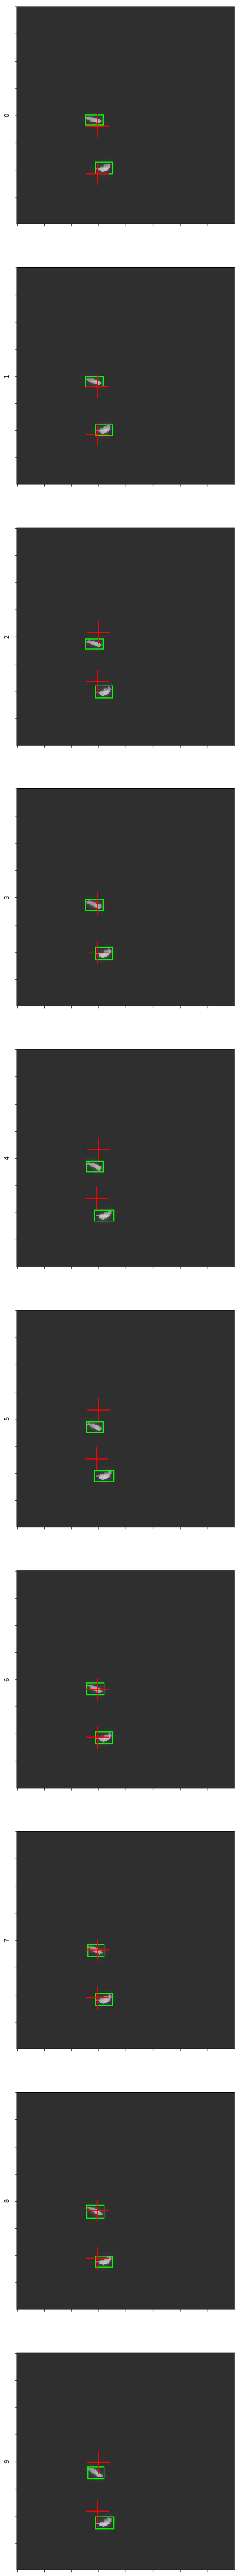

In [215]:
base = 1200
nb_frames = 10 
f, a = plt.subplots(nrows=nb_frames, figsize=(8*nb_frames,80))
for i in range(nb_frames):
    a[i].xaxis.set_ticklabels([])
    a[i].yaxis.set_ticklabels([])
    a[i].set_ylabel(i)
    a[i].imshow(frames_with_boxes[base+i][400:600,900:1100])

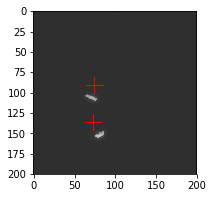

In [185]:
plt.figure(figsize=(3,3))
plt.imshow(frames_with_boxes[1203][400:600,900:1100])

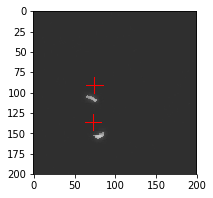

In [186]:
plt.figure(figsize=(3,3))
plt.imshow(frames_with_boxes[1204][400:600,900:1100])

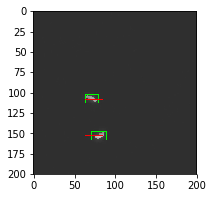

In [187]:
plt.figure(figsize=(3,3))
plt.imshow(frames_with_boxes[1205][400:600,900:1100])

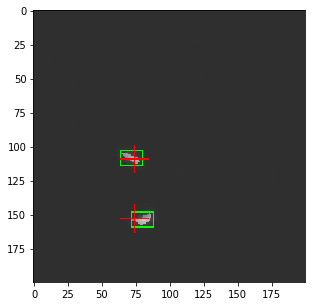

In [175]:
plt.figure(figsize=(5,5))
plt.imshow(frames_with_boxes[1206][400:600,900:1100])

In [217]:
bboxes

[[None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None],
 [None, (474, 0, 479, 3), None, None, None, None, None, None, None, None],
 [None, (474, 0, 479, 3), None, None, None, None, None, None, None, None],
 [None, (474, 0, 479, 4), None, None, None, None, None, None, None, None],
 [None, (473, 0, 479, 5), None, None, None, None, None, None, None, None],
 [None,
  (473, 0, 479, 7),
  (495, 0, 500, 3),
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 [None,
  (473, 0, 479, 7),
  (496, 0, 501, 2),
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 [None,
  (473, 0, 479, 8),
  (495, 0, 501, 4),
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 [None,
  (473, 0, 479, 9),
  (495, 0, 501, 4),
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 [None,
  (473, 0, 479, 10),

In [229]:
video = cv2.VideoWriter('data/arma_generated/20fps_sample/annotated_with_markers.mp4',
                        cv2.VideoWriter_fourcc(*'MP4V'),
                        20, (1280,720), True)

for fr in frames_with_boxes:
    video.write(fr)

video.release()

In [231]:
annotation['bounding_boxes'] = bboxes

In [235]:
with open('./data/arma_generated/20fps_sample/bbox_annotation.p', 'wb') as f:
    pkl.dump(annotation, f)

In [234]:
annotation

,timestamp,frame,objects,bounding_boxes
0,2018-12-10 16:22:04,0,"[[454.903, -21.7134], [476.824, -9.25929], [498.533, -6.07463], [934.065, -579.122], [995.605, -594.476], [882.837, -1245.65], [812.231, -1279.96], [850.914, -1408.31], [1413.81, -3433.38], [1658.82, -3903.72]]","[None, None, None, None, None, None, None, None, None, None]"
1,2018-12-10 16:22:04,1,"[[454.903, -21.7134], [476.824, -9.25929], [498.533, -6.07463], [934.065, -579.122], [995.605, -594.476], [882.837, -1245.65], [812.231, -1279.96], [850.914, -1408.31], [1413.81, -3433.38], [1658.82, -3903.72]]","[None, None, None, None, None, None, None, None, None, None]"
2,2018-12-10 16:22:04,2,"[[454.901, -17.7646], [476.782, -5.20606], [498.532, -2.11599], [935.191, -575.456], [985.804, -585.876], [882.842, -1240.39], [812.236, -1274.7], [850.607, -1400.23], [1415.42, -3432.78], [1659.13, -3895.54]]","[None, None, None, None, None, None, None, None, None, None]"
3,2018-12-10 16:22:04,3,"[[454.902, -19.3441], [476.782, -6.78994], [498.532, -3.69943], [935.189, -577.402], [990.083, -587.639], [882.84, -1242.49], [812.234, -1276.8], [850.605, -1402.41], [1415.41, -3435.89], [1659.12, -3898.94]]","[None, None, None, None, None, None, None, None, None, None]"
4,2018-12-10 16:22:04,4,"[[454.902, -19.3441], [476.782, -6.78994], [498.532, -3.69943], [935.189, -577.402], [990.083, -587.639], [882.84, -1242.49], [812.234, -1276.8], [850.605, -1402.41], [1415.41, -3435.89], [1659.12, -3898.94]]","[None, (474, 0, 479, 3), None, None, None, None, None, None, None, None]"
5,2018-12-10 16:22:04,5,"[[454.902, -19.3441], [476.782, -6.78994], [498.532, -3.69943], [935.189, -577.402], [990.083, -587.639], [882.84, -1242.49], [812.234, -1276.8], [850.605, -1402.41], [1415.41, -3435.89], [1659.12, -3898.94]]","[None, (474, 0, 479, 3), None, None, None, None, None, None, None, None]"
6,2018-12-10 16:22:04,6,"[[454.902, -19.3441], [476.782, -6.78994], [498.532, -3.69943], [935.189, -577.402], [990.083, -587.639], [882.84, -1242.49], [812.234, -1276.8], [850.605, -1402.41], [1415.41, -3435.89], [1659.12, -3898.94]]","[None, (474, 0, 479, 4), None, None, None, None, None, None, None, None]"
7,2018-12-10 16:22:04,7,"[[454.902, -19.3441], [476.782, -6.78994], [498.532, -3.69943], [935.189, -577.402], [990.083, -587.639], [882.84, -1242.49], [812.234, -1276.8], [850.605, -1402.41], [1415.41, -3435.89], [1659.12, -3898.94]]","[None, (473, 0, 479, 5), None, None, None, None, None, None, None, None]"
8,2018-12-10 16:22:04,8,"[[454.902, -19.3441], [476.782, -6.78994], [498.532, -3.69943], [935.189, -577.402], [990.083, -587.639], [882.84, -1242.49], [812.234, -1276.8], [850.605, -1402.41], [1415.41, -3435.89], [1659.12, -3898.94]]","[None, (473, 0, 479, 7), (495, 0, 500, 3), None, None, None, None, None, None, None]"
9,2018-12-10 16:22:04,9,"[[454.902, -19.3441], [476.782, -6.78994], [498.532, -3.69943], [935.189, -577.402], [990.083, -587.639], [882.84, -1242.49], [812.234, -1276.8], [850.605, -1402.41], [1415.41, -3435.89], [1659.12, -3898.94]]","[None, (473, 0, 479, 7), (496, 0, 501, 2), None, None, None, None, None, None, None]"
